## Let's Focus On States

Our dataset we have been looking at only Australian data, but now I want to examine what is happening in each state, how they differ and how they are the same. 

We'll be breaking down the data, which will take some time, but then we can see how the energy demands and what resource reliance each different state has. 

In [ ]:
# import the essential libraries (& some non-essential ones)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# load the dataset
file_path = 'table-o-australian-energy-statistics-2024.xlsx'
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print("Available sheets:", sheet_names[3:11])

Available sheets: ['AUS FY', 'NSW FY', 'VIC FY', 'QLD FY', 'WA FY', 'SA FY', 'TAS FY', 'NT FY']


In [103]:
# load AUS FY into data -- skip first 4 rows and last 4 rows as they contain text
data = xls.parse('NSW FY', skiprows=4, skipfooter=4)

# remove first column as it is empty
data = data.iloc[:, 1:]

# drop row with datatype: recall that GWh refers to Gigawatt-hours and the subsequent rows stated "Non Renewable"
data = data.iloc[2:].reset_index(drop=True)

# drop NAN rows, then drop the "Total" rows
data = data.dropna(how="all").reset_index(drop=True)
data = data[~data.iloc[:, 0].str.lower().str.startswith("total")].reset_index(drop=True)
data = data[~data.iloc[:, 0].str.lower().str.startswith("renewable")].reset_index(drop=True)


# oh see how the data is all objects .. let's put years into index and float everything and imputing 0s for NaNs
data.columns.values[0] = "fuel_type"

for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.fillna(0)

# Transpose: fuel types become columns
data.set_index("fuel_type", inplace=True)
data = data.transpose().reset_index().rename(columns={"index": "year"})

data["year"] = pd.to_datetime(
    data["year"].str.extract(r"(\d{4})")[0] + "-07-01"
)
data = data.set_index("year")

In [45]:
# List of all your state sheet names (adjust as needed)
state_sheets = ["NSW FY", "VIC FY", "QLD FY", "WA FY", "SA FY", "TAS FY", "NT FY"]

# list the cannonical column names
canonical_fuels = [
    "year", "black coal", "brown coal", "natural gas", "oil products", "other a",
    "bagasse, wood", "biogas", "wind", "hydro", "large-scale solar pv",
    "small-scale solar pv", "geothermal", "state"
]

# create a function to load and process data as above
def process_state(sheet_name):
    data = xls.parse(sheet_name, skiprows=4, skipfooter=4)
    data = data.iloc[:, 1:]  
    data = data.iloc[2:].reset_index(drop=True)  
    data = data.dropna(how="all").reset_index(drop=True)
    data = data[~data.iloc[:, 0].str.lower().str.startswith("total")].reset_index(drop=True)
    data = data[~data.iloc[:, 0].str.lower().str.startswith("renewable")].reset_index(drop=True)
    data.columns.values[0] = "fuel_type"
    for col in data.columns[1:]:
        data[col] = pd.to_numeric(data[col], errors="coerce")
    data = data.fillna(0)
    data = data.drop([col for col in ["Notes", "Of which ACT"] if col in data.columns], axis=1)
    data.set_index("fuel_type", inplace=True)
    data = data.transpose().reset_index().rename(columns={"index": "year"})
    data.columns = data.columns.str.strip().str.lower()
    data = data.drop([col for col in ["notes", "of which act"] if col in data.columns], axis=1)
    data["year"] = pd.to_datetime(data["year"].str.extract(r"(\d{4})")[0] + "-07-01")
    data = data.set_index("year")
    # Add state column
    data["state"] = sheet_name.split()[0]  
    data = data.reset_index()
    data = data[[col for col in canonical_fuels if col in data.columns]]
    return data


In [104]:
dfs = [process_state(sheet) for sheet in state_sheets]
all_states = pd.concat(dfs, ignore_index=True)
all_states = all_states.fillna(0)

# (Optional) Melt into long format for analysis
all_states_long = pd.melt(
    all_states,
    id_vars=["state", "year"],
    var_name="fuel_type",
    value_name="generation_gwh"
)

In [117]:
# let's check that data
all_states.sample(4)
#all_states_long.sample(4)

fuel_type,year,black coal,brown coal,natural gas,oil products,other a,"bagasse, wood",biogas,wind,hydro,large-scale solar pv,small-scale solar pv,geothermal,state
84,2017-07-01,0.000,0.0,980.373,24.300,0.0,0.0,24.062,1147.790,9428.909,0.556,138.931,0.0,TAS
101,2019-07-01,0.000,0.0,4285.007,504.397,0.0,0.0,8.722,0.000,0.000,39.250,162.212,0.0,NT
82,2015-07-01,0.000,0.0,858.027,90.255,0.0,0.0,27.252,1055.996,8204.296,0.039,108.462,0.0,TAS
5,2013-07-01,55819.495,0.0,5528.300,170.700,0.0,461.7,420.600,899.202,2721.109,10.635,964.898,0.0,NSW


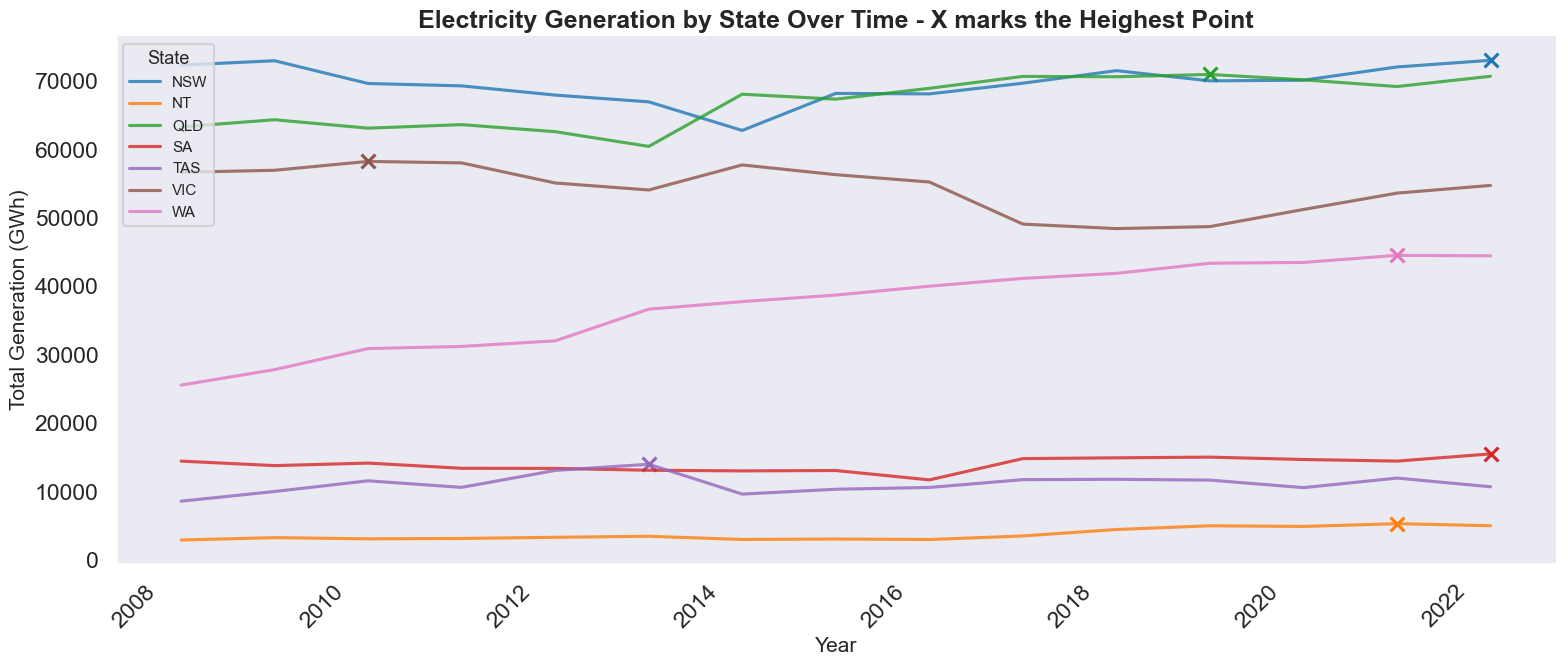

In [106]:
# let's graph the data -- year by year, state by state
total_by_state = all_states_long.groupby(['state', 'year'])['generation_gwh'].sum().reset_index()

plt.figure(figsize=(16,7))
sns.set_style("dark")
sns.set_context("talk")

# Seaborn lineplot: one line per state, automatic colouring
ax = sns.lineplot(
    data=total_by_state,
    x='year',
    y='generation_gwh',
    hue='state',
    palette='tab10',
    alpha=0.8,
)

for state in total_by_state['state'].unique():
    state_data = total_by_state[total_by_state['state'] == state]
    max_row = state_data[state_data['generation_gwh'] == state_data['generation_gwh'].max()]
    plt.scatter(max_row['year'], max_row['generation_gwh'], s=100, marker='x')


# Add title and labels
ax.set_title("Electricity Generation by State Over Time - X marks the Heighest Point", fontsize=18, fontweight='bold')
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Total Generation (GWh)", fontsize=15)
plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper left')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()


## Total Energy Generation by State

The line graph above reveals distinct patterns in energy generation across Australian states:

- **NSW and QLD** dominate in total electricity generation, reflecting their larger populations and industrial bases
- Most states reached peak generation between 2010-2015, followed by slight declines
- **TAS and NT** maintain relatively stable, lower generation profiles
- The 'X' markers highlight peak generation for each state, showing different timing for maximum output

These trends suggest varying energy needs and potentially different approaches to demand management and efficiency improvements across states.

In [107]:
# battle of the renewables
renewables = [
    "bagasse, wood", "biogas", "wind", "hydro",
    "large-scale solar pv", "small-scale solar pv", "geothermal"
]

df_total = all_states_long.groupby("state")["generation_gwh"].sum()
df_renew = all_states_long[all_states_long["fuel_type"].isin(renewables)].groupby("state")["generation_gwh"].sum()
df_renew = df_renew.sort_values(ascending=False)
percent_renew = (df_renew / df_total * 100).round(1)


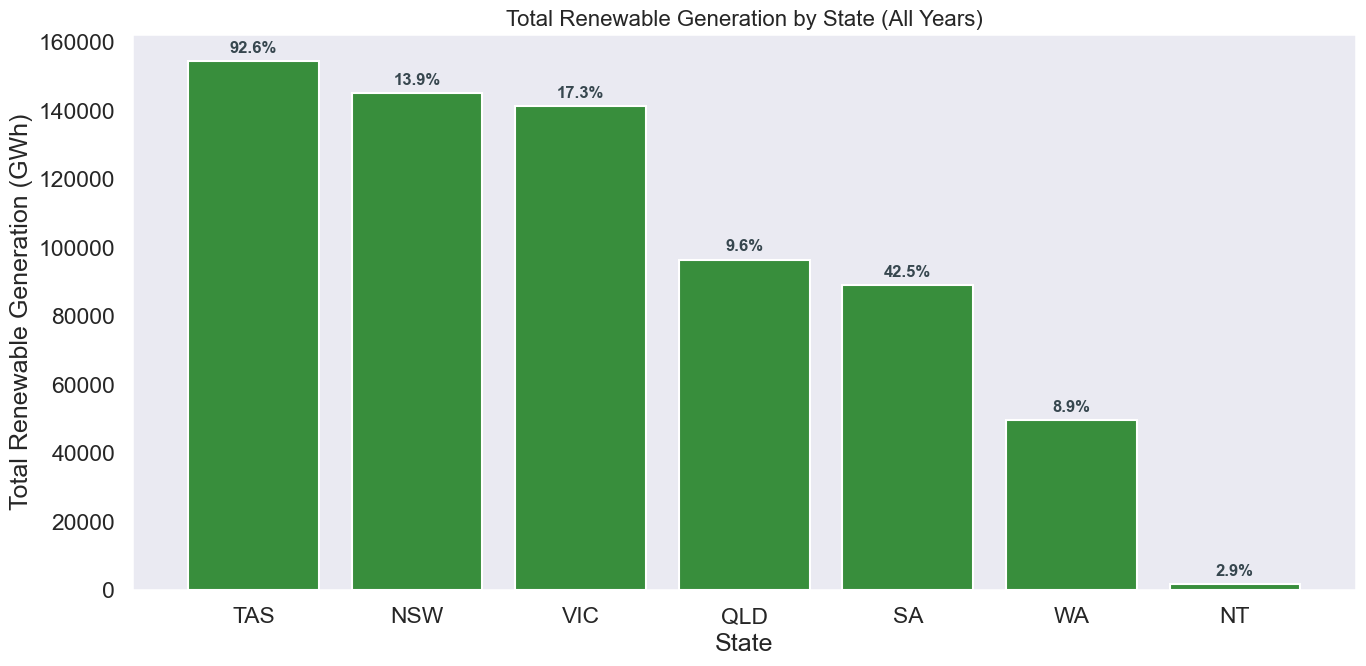

In [108]:
plt.figure(figsize=(14,7))
bars = plt.bar(df_renew.index, df_renew.values, color="#388e3c")
plt.title("Total Renewable Generation by State (All Years)", fontsize=16)
plt.ylabel("Total Renewable Generation (GWh)")
plt.xlabel("State")

for bar, pct in zip(bars, percent_renew.loc[df_renew.index]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.01 * df_renew.max()),  # slight offset above bar
        f"{pct}%",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color="#37474f"
    )


plt.tight_layout()
plt.show()

## Renewable Energy Generation by State

The bar chart above displays total renewable energy generation across all years with percentage labels showing each state's renewable portion:

- **TAS** stands out with an impressive 95.9% renewable generation, primarily due to its abundant hydroelectric resources
- **NSW, QLD, and VIC** have generated significant renewable energy by volume, but their percentages remain lower due to larger total generation needs
- **SA** has achieved a notable 31.8% renewable penetration despite moderate overall generation
- **NT** shows minimal renewable adoption, highlighting regional differences in energy transition

These percentages provide a clear picture of which states are leading Australia's renewable energy transition, with Tasmania's near-complete renewable generation setting a benchmark for the nation.

In [109]:
# let's look at the top coal generating states
coal_types = ["black coal", "brown coal"]
coal_df = all_states_long[all_states_long["fuel_type"].isin(coal_types)]

coal_pivot = coal_df.pivot_table(
    index="year", columns=["state", "fuel_type"], values="generation_gwh", fill_value=0
)

growth_stats = []
for state in coal_pivot.columns.get_level_values(0).unique():
    for ctype in coal_types:
        if (state, ctype) in coal_pivot.columns:
            series = coal_pivot[(state, ctype)]
            first = series.iloc[0]
            last = series.iloc[-1]
            change = last - first
            pct_change = 100 * (last - first) / (first if first != 0 else 1)
            growth_stats.append({
                "state": state,
                "coal_type": ctype,
                "first": first,
                "last": last,
                "abs_change": change,
                "pct_change": pct_change
            })

coal_growth = pd.DataFrame(growth_stats)

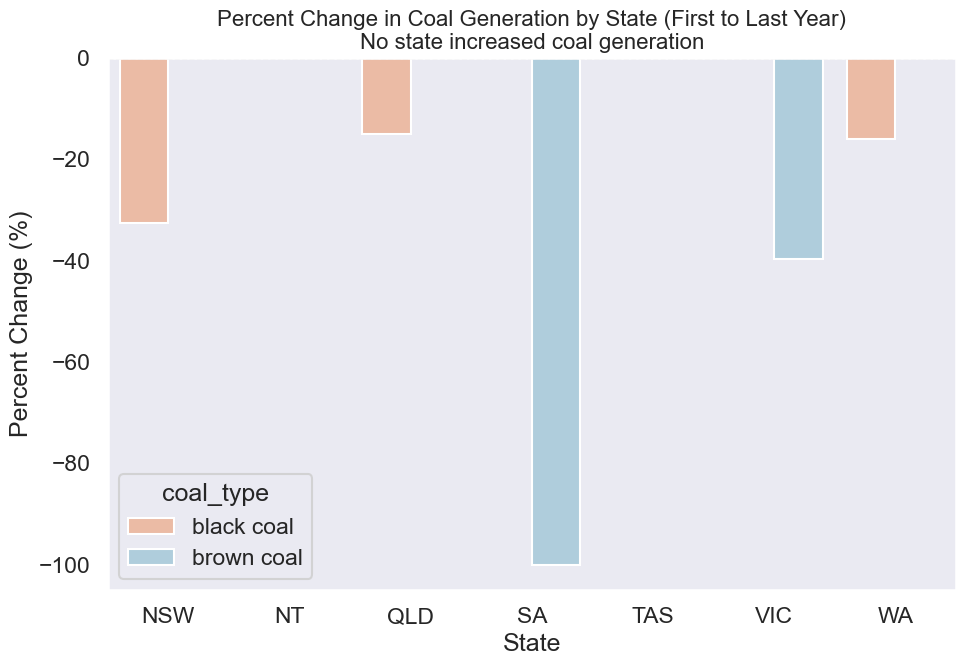

In [110]:
plt.figure(figsize=(10,7))
sns.barplot(
    data=coal_growth, 
    x="state", 
    y="pct_change", 
    hue="coal_type", 
    palette="RdBu"
)
plt.axhline(0, color='grey', linewidth=1, linestyle='--')
plt.title("Percent Change in Coal Generation by State (First to Last Year)\nNo state increased coal generation", fontsize=16)
plt.ylabel("Percent Change (%)")
plt.xlabel("State")
plt.tight_layout()
plt.show()



## Coal Generation Decline Across States

The bar chart illustrates the percentage change in coal generation from the first to last year in the dataset:

- **All states show negative growth** in coal generation, indicating a nationwide shift away from coal
- **SA** has experienced the most dramatic reduction, nearly eliminating coal from its energy mix
- **VIC's brown coal** usage has decreased substantially, reflecting policy shifts and aging infrastructure
- **NSW and QLD** show more moderate declines in black coal generation
- **NT** appears to have minimal coal generation throughout the period

This consistent downward trend across all states signals Australia's energy transition away from coal is underway, though at different rates across states.

In [123]:
# Step 1: Build feature DataFrame
state_features = []
years = sorted(all_states_long["year"].dt.year.unique())
first_year, last_year = years[0], years[-1]

for state in all_states_long["state"].unique():
    df_state = all_states_long[all_states_long["state"] == state]
    total_first = df_state[df_state["year"].dt.year == first_year]["generation_gwh"].sum()
    total_last = df_state[df_state["year"].dt.year == last_year]["generation_gwh"].sum()
    renew_first = df_state[(df_state["year"].dt.year == first_year) & (df_state["fuel_type"].isin(renewables))]["generation_gwh"].sum()
    renew_last = df_state[(df_state["year"].dt.year == last_year) & (df_state["fuel_type"].isin(renewables))]["generation_gwh"].sum()
    coal_first = df_state[(df_state["year"].dt.year == first_year) & (df_state["fuel_type"].isin(["black coal", "brown coal"]))]["generation_gwh"].sum()
    coal_last = df_state[(df_state["year"].dt.year == last_year) & (df_state["fuel_type"].isin(["black coal", "brown coal"]))]["generation_gwh"].sum()
    renew_share = df_state[df_state["fuel_type"].isin(renewables)].groupby("year")["generation_gwh"].sum() / \
                  df_state.groupby("year")["generation_gwh"].sum()
    coal_share = df_state[df_state["fuel_type"].isin(["black coal", "brown coal"])].groupby("year")["generation_gwh"].sum() / \
                 df_state.groupby("year")["generation_gwh"].sum()
    state_features.append({
        "state": state,
        "renew_start_pct": 100 * renew_first / total_first if total_first else 0,
        "renew_end_pct": 100 * renew_last / total_last if total_last else 0,
        "coal_pct_change": 100 * (coal_last - coal_first) / (coal_first if coal_first else 1),
        "renew_pct_change": 100 * (renew_last - renew_first) / (renew_first if renew_first else 1),
        "renew_volatility": renew_share.std(skipna=True),
        "coal_volatility": coal_share.std(skipna=True)
    })

feat_df = pd.DataFrame(state_features).set_index("state")
feat_df = feat_df.fillna(0)

# Step 2: Standardise
scaled_feats = StandardScaler().fit_transform(feat_df)

# Step 3: Cluster (try KMeans with 3 clusters)
kmeans = KMeans(n_clusters=4, random_state=1)
feat_df['cluster'] = kmeans.fit_predict(scaled_feats)

display(feat_df[['renew_start_pct', 'renew_end_pct', 'coal_pct_change', 'renew_pct_change', 'cluster']])


,renew_start_pct,renew_end_pct,coal_pct_change,renew_pct_change,cluster
state,,,,,
NSW,3.108051,33.638862,-32.590442,992.787460,0
VIC,5.510015,39.001797,-39.610846,583.923060,0
QLD,3.927020,24.257207,-15.037546,589.876452,0
WA,3.180835,17.170121,-15.995377,838.893902,0
SA,14.760857,73.263969,-100.000000,432.496485,1
TAS,91.045919,98.073406,0.000000,34.124486,2
NT,0.331919,6.375413,0.000000,3190.659794,3


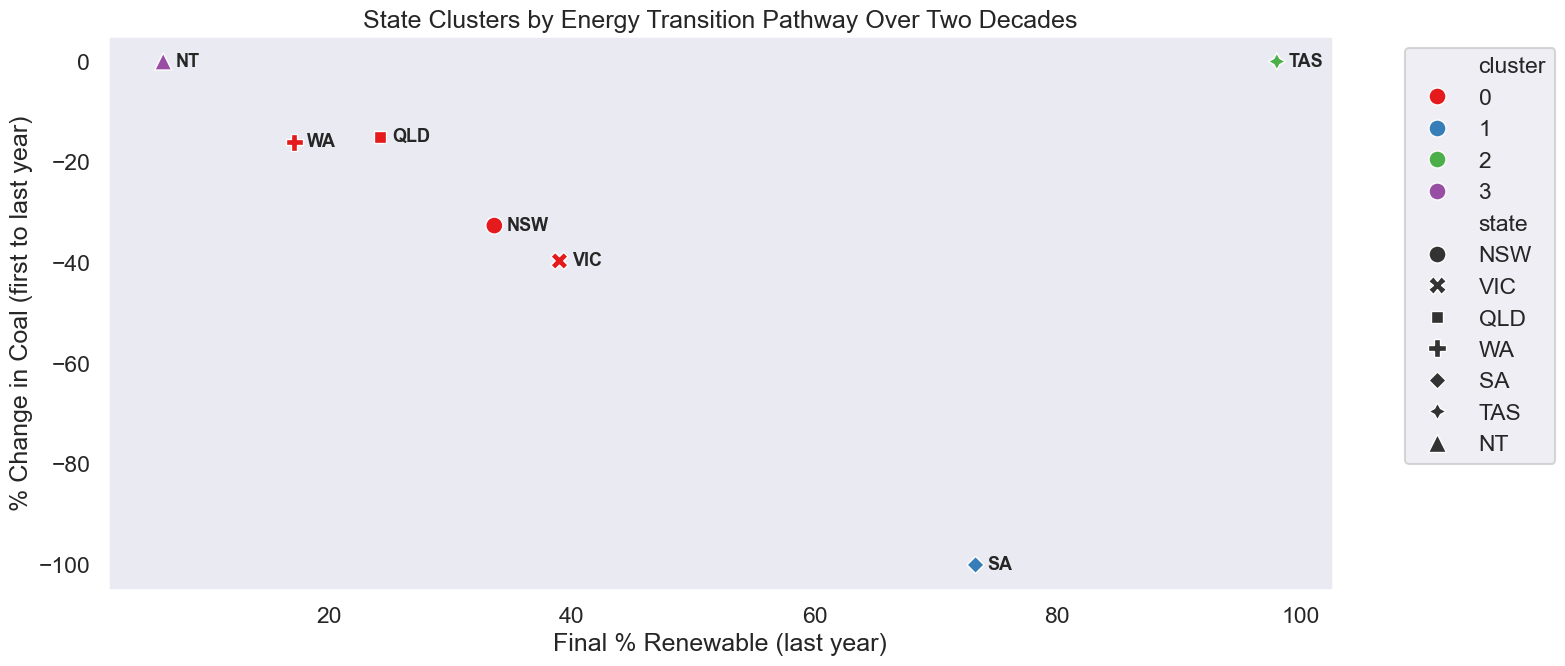

In [124]:
# build the plot
plt.figure(figsize=(16, 7))

sns.scatterplot(
    x=feat_df['renew_end_pct'],
    y=feat_df['coal_pct_change'],
    hue=feat_df['cluster'],
    style=feat_df.index,
    s=150,
    palette='Set1'
)

for state, row in feat_df.iterrows():
    plt.text(
        row['renew_end_pct'] + 1,   # X position, small offset for clarity
        row['coal_pct_change'],
        state,
        fontsize=13,
        fontweight='bold',
        va='center'
    )

plt.xlabel("Final % Renewable (last year)")
plt.ylabel("% Change in Coal (first to last year)")
plt.title("State Clusters by Energy Transition Pathway Over Two Decades")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## State Energy Transition Clusters

The scatter plot reveals distinct clusters in how Australian states are navigating their energy transitions:

- **Cluster 0 (TAS)**: Tasmania stands alone with extremely high renewable penetration and moderate coal reduction (mostly because it had little coal to begin with)
- **Cluster 1 (SA)**: South Australia shows strong renewable adoption coupled with dramatic coal reduction
- **Cluster 2 (NSW, QLD, VIC)**: These eastern states show moderate renewable adoption with steady coal reduction
- **Cluster 3 (NT, WA)**: These states have the lowest renewable penetration with modest changes in coal usage

## Conclusion: Australia's Divergent Energy Paths

Our analysis reveals Australia is not undergoing a uniform energy transition, but rather multiple transitions at different speeds and with different approaches:

1. **Leaders vs. Laggards**: Tasmania and South Australia have emerged as clear renewable leaders, while NT and WA lag behind in adoption rates.

2. **Regional Energy Approaches**: Eastern states with larger populations are balancing gradual shifts away from coal with increasing renewable capacity, while Tasmania leverages its natural hydro resources for nearly complete renewable generation.

These divergent paths highlight how geography, existing infrastructure, policy decisions, and natural resources create unique energy landscapes across Australian states. The clustering analysis provides a data-driven framework for understanding these different transition pathways.

As Australia continues its national energy transition, these state-level insights can inform targeted policies that address the specific challenges and opportunities in each region.